## Color quantization variant 2
Attempt to generate a unique key based on colors and their percentages in the image

In [24]:
import numpy as np
import cv2
from sklearn.cluster import KMeans, MiniBatchKMeans
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import heapq
from ntpath import basename
import plotly.graph_objs as go
from collections import Counter

In [125]:
paths = glob('../data/Biscuits/*.png')

In [155]:
def get_image(path):
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rgb2hex(c):
    
    return '#{:02x}{:02x}{:02x}'.format(int(c[0]), int(c[1]), int(c[2]))


def extract_colors(img, n_components):
    
    # Reshape for KMeans
    img = img.reshape(img.shape[0]*img.shape[1], -1)
    
    # KMeans
    clf = MiniBatchKMeans(n_clusters=n_components)
    clf.fit(img)
    
    # Get top colors
    centers = clf.cluster_centers_
    labels = clf.labels_
    
    return centers, labels


def color_histogram(centers, labels, normalize=True):
        
    counts = Counter(labels)
    max_value_id = np.argmax(counts.values())
    max_label_locations = np.where(labels == list(counts.keys())[max_value_id])[0]
    labels = np.delete(labels, max_label_locations)
    centers = np.array(list(centers[:max_value_id]) + list(centers[max_value_id+1:]))
    label_ids = np.delete(np.array(list(counts.keys())), max_value_id)
    num_labels = np.arange(0, len(label_ids)+1)
    (hist, _) = np.histogram(labels, bins=num_labels)

    if normalize:
        hist = hist / sum(hist)
        
    return hist, centers, label_ids


def show_colors(centers):
    
    fig = plt.figure()
    
    for i in range(len(centers)):
        c = centers[i]/255.
        fig.add_subplot(1, len(centers), i+1)
        plt.imshow([[(c[0], c[1], c[2])]])
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
    

def get_colorbar(hist, centers):
    
    bar = np.zeros((1, 100, 3), dtype=np.uint8)
    startX = 0
    
    for (percent, color) in zip(hist, centers):
        endX = startX + percent*100
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50), color.astype('uint8').tolist(), -1)
        startX = endX
        
    return bar

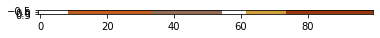

In [156]:
img = get_image(paths[1])
centers, labels = extract_colors(img, n_components=10)
hist, centers, label_ids = color_histogram(centers, labels, normalize=True)
bar = get_colorbar(hist, centers)

plt.imshow(bar)